# Эксперименты: Сравнение семейств моделей для классификации изображений

**Цель:** Провести комплексные эксперименты с двумя семействами моделей из библиотеки `timm` для классификации изображений трех классов (keyboard, mouse, soundcard).

**Задачи:**
1. Выбрать две модели из разных семейств (ResNet и EfficientNet)
2. Реализовать стратегии замораживания/размораживания весов
3. Настроить аугментации данных
4. Провести подбор гиперпараметров
5. Сравнить результаты и выбрать лучшую модель

**Модели для сравнения:**
- ResNet18 (семейство ResNet)
- EfficientNet-B0 (семейство EfficientNet)


## 1. Импорт библиотек и настройка окружения


In [2]:
import os
import sys
import random
import json
import time
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import timm

# Для датасета и аугментаций
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

# Метрики
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Подавление предупреждений
warnings.filterwarnings('ignore')

print(f"PyTorch: {torch.__version__}")
print(f"timm: {timm.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")


C:\Users\delja\PycharmProjects\fine-tuning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch: 2.9.0+cpu
timm: 1.0.20
CUDA available: False


## 2. Настройка путей и параметров


In [3]:
# Настройки путей - ВАЖНО: используем правильные пути относительно корня проекта
ROOT = Path(".").resolve()
# Переходим в корень проекта (на уровень выше от experiments/notebooks)
ROOT = ROOT.parent.parent if "experiments" in str(ROOT) else ROOT

DATA_DIR = ROOT / "data" / "raw"
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "val"
OUT_DIR = ROOT / "models"
LOGS_DIR = ROOT / "experiments" / "logs"
RESULTS_DIR = ROOT / "experiments" / "results"

# Создание директорий
for dir_path in [OUT_DIR, LOGS_DIR, RESULTS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Базовые параметры
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
IMAGE_SIZE = 224

print(f"ROOT: {ROOT}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"TRAIN_DIR: {TRAIN_DIR}")
print(f"VAL_DIR: {VAL_DIR}")
print(f"DEVICE: {DEVICE}")
print(f"OUT_DIR: {OUT_DIR}")
print(f"LOGS_DIR: {LOGS_DIR}")

# Проверка существования папок
print(f"\nПроверка папок:")
print(f"DATA_DIR exists: {DATA_DIR.exists()}")
print(f"TRAIN_DIR exists: {TRAIN_DIR.exists()}")
print(f"VAL_DIR exists: {VAL_DIR.exists()}")


ROOT: C:\Users\delja\PycharmProjects\fine-tuning
DATA_DIR: C:\Users\delja\PycharmProjects\fine-tuning\data\raw
TRAIN_DIR: C:\Users\delja\PycharmProjects\fine-tuning\data\raw\train
VAL_DIR: C:\Users\delja\PycharmProjects\fine-tuning\data\raw\val
DEVICE: cpu
OUT_DIR: C:\Users\delja\PycharmProjects\fine-tuning\models
LOGS_DIR: C:\Users\delja\PycharmProjects\fine-tuning\experiments\logs

Проверка папок:
DATA_DIR exists: True
TRAIN_DIR exists: True
VAL_DIR exists: True


## 3. Вспомогательные функции


In [4]:
def set_seed(seed: int = 42):
    """Установка seed для воспроизводимости"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def freeze_backbone(model, freeze: bool = True):
    """Замораживание/размораживание backbone модели"""
    for name, param in model.named_parameters():
        if 'head' in name or 'classifier' in name or 'fc' in name:
            param.requires_grad = True  # Классификатор всегда обучается
        else:
            param.requires_grad = not freeze

def count_parameters(model):
    """Подсчет количества параметров"""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def save_experiment_results(results: Dict, model_name: str, timestamp: str):
    """Сохранение результатов эксперимента"""
    results_path = RESULTS_DIR / f"{model_name}_{timestamp}.json"
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=2)
    print(f"Результаты сохранены: {results_path}")

set_seed(SEED)


## 4. Загрузка и анализ данных


Классы в тренировочном наборе: ['keyboard', 'mouse', 'soundcard']
Классы в валидационном наборе: ['keyboard', 'mouse', 'soundcard']

Количество изображений по классам:
Тренировочный набор: {'keyboard': 32, 'mouse': 32, 'soundcard': 32}
Валидационный набор: {'keyboard': 10, 'mouse': 10, 'soundcard': 10}


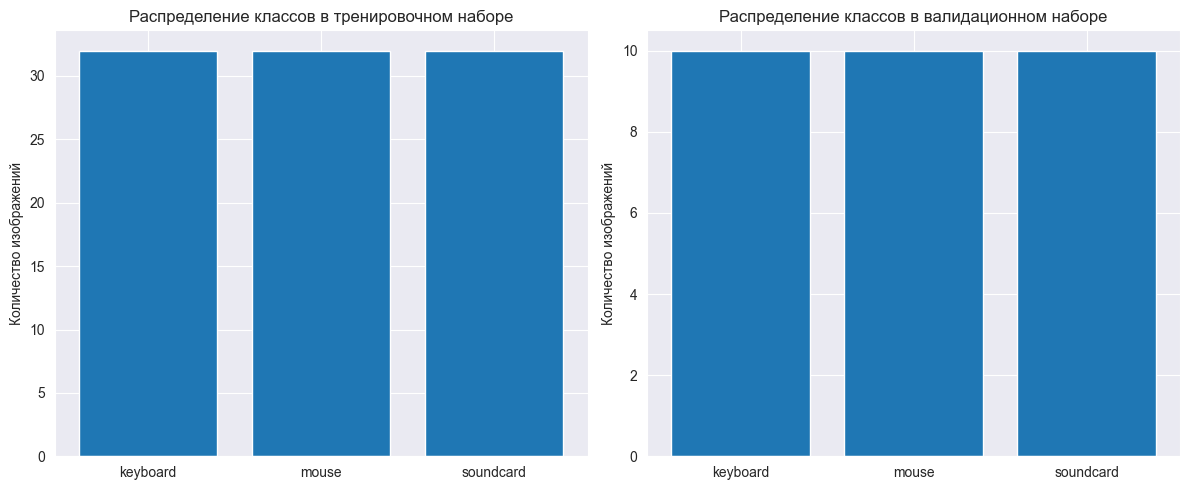

In [5]:
# Проверка структуры данных
assert TRAIN_DIR.exists(), f"Не найдена папка {TRAIN_DIR}"
assert VAL_DIR.exists(), f"Не найдена папка {VAL_DIR}"

train_classes = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
val_classes = sorted([d.name for d in VAL_DIR.iterdir() if d.is_dir()])

print("Классы в тренировочном наборе:", train_classes)
print("Классы в валидационном наборе:", val_classes)

# Подсчет количества изображений по классам
train_counts = {}
val_counts = {}

for cls in train_classes:
    cls_dir = TRAIN_DIR / cls
    files = list(cls_dir.glob("*.jpg")) + list(cls_dir.glob("*.jpeg")) + list(cls_dir.glob("*.png"))
    train_counts[cls] = len(files)

for cls in val_classes:
    cls_dir = VAL_DIR / cls
    files = list(cls_dir.glob("*.jpg")) + list(cls_dir.glob("*.jpeg")) + list(cls_dir.glob("*.png"))
    val_counts[cls] = len(files)

print("\nКоличество изображений по классам:")
print("Тренировочный набор:", train_counts)
print("Валидационный набор:", val_counts)

# Визуализация распределения классов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(train_counts.keys(), train_counts.values())
ax1.set_title('Распределение классов в тренировочном наборе')
ax1.set_ylabel('Количество изображений')

ax2.bar(val_counts.keys(), val_counts.values())
ax2.set_title('Распределение классов в валидационном наборе')
ax2.set_ylabel('Количество изображений')

plt.tight_layout()
plt.show()


## 5. Создание датасета с аугментациями


In [6]:
# Импорт классов из experiments/datasets.py
import sys
sys.path.append(str(ROOT / "experiments"))

from experiments.datasets import ImageFolderSimple, get_transforms

# Создание датасетов
train_t, val_t = get_transforms(IMAGE_SIZE)
train_ds = ImageFolderSimple(str(TRAIN_DIR), transform=train_t)
val_ds = ImageFolderSimple(str(VAL_DIR), transform=val_t, classes=list(train_ds.class_to_idx.keys()))

class_names = list(train_ds.class_to_idx.keys())
num_classes = len(class_names)

print(f"Классы: {class_names}")
print(f"Количество классов: {num_classes}")
print(f"Тренировочных образцов: {len(train_ds)}")
print(f"Валидационных образцов: {len(val_ds)}")

Классы: ['keyboard', 'mouse', 'soundcard']
Количество классов: 3
Тренировочных образцов: 96
Валидационных образцов: 30


## 6. Конфигурации экспериментов


In [7]:
# Конфигурации для экспериментов
EXPERIMENT_CONFIGS = {
    'resnet18': {
        'model_name': 'resnet18',
        'family': 'ResNet',
        'hyperparams': {
            'batch_size': 16,
            'lr': 1e-3,
            'weight_decay': 1e-4,
            'epochs': 12,
            'freeze_backbone': True,
            'unfreeze_at_epoch': 5
        }
    },
    'efficientnet_b0': {
        'model_name': 'efficientnet_b0',
        'family': 'EfficientNet',
        'hyperparams': {
            'batch_size': 16,
            'lr': 1e-3,
            'weight_decay': 1e-4,
            'epochs': 12,
            'freeze_backbone': True,
            'unfreeze_at_epoch': 5
        }
    }
}

print("Конфигурации экспериментов:")
for model_name, config in EXPERIMENT_CONFIGS.items():
    print(f"\n{model_name} ({config['family']}):")
    for key, value in config['hyperparams'].items():
        print(f"  {key}: {value}")


Конфигурации экспериментов:

resnet18 (ResNet):
  batch_size: 16
  lr: 0.001
  weight_decay: 0.0001
  epochs: 12
  freeze_backbone: True
  unfreeze_at_epoch: 5

efficientnet_b0 (EfficientNet):
  batch_size: 16
  lr: 0.001
  weight_decay: 0.0001
  epochs: 12
  freeze_backbone: True
  unfreeze_at_epoch: 5


## 7. Функция обучения модели


In [8]:
def train_model(model_name: str, config: Dict, train_loader: DataLoader, val_loader: DataLoader) -> Dict:
    """Обучение модели с заданной конфигурацией"""
    
    print(f"\n{'='*50}")
    print(f"Обучение модели: {model_name}")
    print(f"Семейство: {config['family']}")
    print(f"{'='*50}")
    
    # Создание модели
    model = timm.create_model(
        config['model_name'], 
        pretrained=True, 
        num_classes=num_classes
    )
    model.to(DEVICE)
    
    # Подсчет параметров
    total_params, trainable_params = count_parameters(model)
    print(f"Всего параметров: {total_params:,}")
    print(f"Обучаемых параметров: {trainable_params:,}")
    
    # Замораживание backbone
    if config['hyperparams']['freeze_backbone']:
        freeze_backbone(model, freeze=True)
        _, frozen_trainable = count_parameters(model)
        print(f"Обучаемых параметров после замораживания: {frozen_trainable:,}")
    
    # Оптимизатор и планировщик
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config['hyperparams']['lr'],
        weight_decay=config['hyperparams']['weight_decay']
    )
    
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, 
        step_size=5, 
        gamma=0.1
    )
    
    criterion = nn.CrossEntropyLoss()
    
    # История обучения
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }
    
    best_val_acc = 0.0
    best_epoch = 0
    
    # Цикл обучения
    for epoch in range(1, config['hyperparams']['epochs'] + 1):
        # Обучение
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
        
        train_loss /= train_total
        train_acc = train_correct / train_total
        
        # Валидация
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * imgs.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                
                all_preds.extend(preds.cpu().numpy().tolist())
                all_labels.extend(labels.cpu().numpy().tolist())
        
        val_loss /= val_total
        val_acc = val_correct / val_total
        
        # Сохранение истории
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        print(f"Epoch {epoch:2d}/{config['hyperparams']['epochs']}: "
              f"Train Loss={train_loss:.4f} | Train Acc={train_acc:.4f} | "
              f"Val Loss={val_loss:.4f} | Val Acc={val_acc:.4f} | "
              f"LR={optimizer.param_groups[0]['lr']:.2e}")
        
        # Сохранение лучшей модели
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            torch.save(model.state_dict(), OUT_DIR / f"best_{model_name}.pth")
            print(f"💾 Сохранена лучшая модель (Val Acc: {val_acc:.4f})")
        
        # Размораживание backbone
        if (config['hyperparams']['freeze_backbone'] and 
            epoch == config['hyperparams']['unfreeze_at_epoch']):
            freeze_backbone(model, freeze=False)
            # Уменьшаем learning rate
            for g in optimizer.param_groups:
                g['lr'] *= 0.1
            print(f"🔓 Разморожен backbone на эпохе {epoch}, LR уменьшен в 10 раз")
        
        scheduler.step()
    
    # Финальные результаты
    results = {
        'model_name': model_name,
        'family': config['family'],
        'best_val_acc': best_val_acc,
        'best_epoch': best_epoch,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'history': history,
        'config': config
    }
    
    print(f"\n✅ Обучение завершено! Лучшая точность: {best_val_acc:.4f} (эпоха {best_epoch})")
    
    return results


## 8. Проведение экспериментов


In [9]:
# Создание DataLoader'ов
# Используем num_workers=0 для Windows, чтобы избежать проблем с multiprocessing
train_loader = DataLoader(
    train_ds, 
    batch_size=16, 
    shuffle=True, 
    num_workers=0  # Изменено с 2 на 0 для Windows
)
val_loader = DataLoader(
    val_ds, 
    batch_size=16, 
    shuffle=False, 
    num_workers=0  # Изменено с 2 на 0 для Windows
)

print(f"Размер батча: {train_loader.batch_size}")
print(f"Количество батчей в эпохе: {len(train_loader)}")
print(f"Количество валидационных батчей: {len(val_loader)}")


Размер батча: 16
Количество батчей в эпохе: 6
Количество валидационных батчей: 2


In [10]:
# Проведение экспериментов
all_results = {}
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

for model_name, config in EXPERIMENT_CONFIGS.items():
    print(f"\n🚀 Начинаем эксперимент с {model_name}")
    
    # Обучение модели
    results = train_model(model_name, config, train_loader, val_loader)
    all_results[model_name] = results
    
    # Сохранение результатов
    save_experiment_results(results, model_name, timestamp)

print(f"\n🎉 Все эксперименты завершены!")
print(f"Результаты сохранены в {RESULTS_DIR}")



🚀 Начинаем эксперимент с resnet18

Обучение модели: resnet18
Семейство: ResNet
Всего параметров: 11,178,051
Обучаемых параметров: 11,178,051
Обучаемых параметров после замораживания: 1,539
Epoch  1/12: Train Loss=1.1006 | Train Acc=0.3646 | Val Loss=1.0294 | Val Acc=0.5667 | LR=1.00e-03
💾 Сохранена лучшая модель (Val Acc: 0.5667)
Epoch  2/12: Train Loss=1.0190 | Train Acc=0.5625 | Val Loss=0.9481 | Val Acc=0.8333 | LR=1.00e-03
💾 Сохранена лучшая модель (Val Acc: 0.8333)
Epoch  3/12: Train Loss=0.9350 | Train Acc=0.8021 | Val Loss=0.8868 | Val Acc=0.9000 | LR=1.00e-03
💾 Сохранена лучшая модель (Val Acc: 0.9000)
Epoch  4/12: Train Loss=0.8353 | Train Acc=0.9167 | Val Loss=0.8274 | Val Acc=0.8667 | LR=1.00e-03
Epoch  5/12: Train Loss=0.7927 | Train Acc=0.8958 | Val Loss=0.7737 | Val Acc=0.9000 | LR=1.00e-03
🔓 Разморожен backbone на эпохе 5, LR уменьшен в 10 раз
Epoch  6/12: Train Loss=0.7638 | Train Acc=0.9167 | Val Loss=0.7711 | Val Acc=0.9000 | LR=1.00e-05
Epoch  7/12: Train Loss=0.749

## 9. Анализ и визуализация результатов


Сравнение моделей:
          Model       Family  Best Val Accuracy  Best Epoch  Total Params  Trainable Params
       resnet18       ResNet           0.933333          10      11178051          11178051
efficientnet_b0 EfficientNet           0.966667           2       4011391           4011391


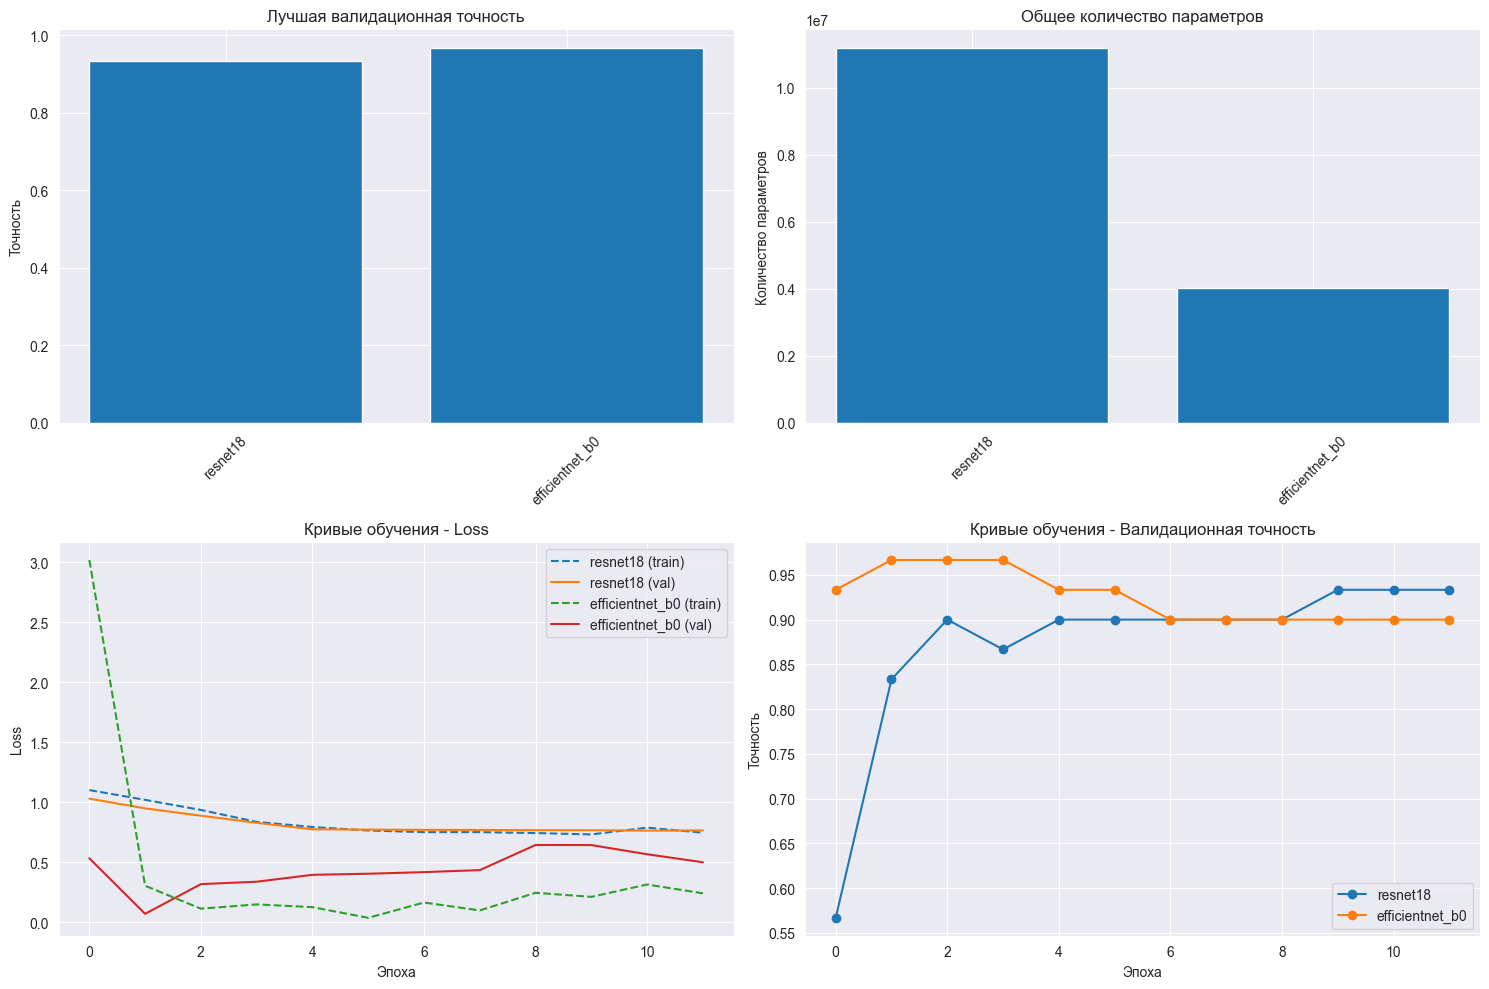

In [14]:
# Сравнение результатов
comparison_data = []
for model_name, results in all_results.items():
    comparison_data.append({
        'Model': model_name,
        'Family': results['family'],
        'Best Val Accuracy': results['best_val_acc'],
        'Best Epoch': results['best_epoch'],
        'Total Params': results['total_params'],
        'Trainable Params': results['trainable_params']
    })

comparison_df = pd.DataFrame(comparison_data)
print("Сравнение моделей:")
print(comparison_df.to_string(index=False))

# Визуализация сравнения
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Точность
axes[0, 0].bar(comparison_df['Model'], comparison_df['Best Val Accuracy'])
axes[0, 0].set_title('Лучшая валидационная точность')
axes[0, 0].set_ylabel('Точность')
axes[0, 0].tick_params(axis='x', rotation=45)

# Количество параметров
axes[0, 1].bar(comparison_df['Model'], comparison_df['Total Params'])
axes[0, 1].set_title('Общее количество параметров')
axes[0, 1].set_ylabel('Количество параметров')
axes[0, 1].tick_params(axis='x', rotation=45)

# Кривые обучения - Loss
for model_name, results in all_results.items():
    axes[1, 0].plot(results['history']['train_loss'], label=f'{model_name} (train)', linestyle='--')
    axes[1, 0].plot(results['history']['val_loss'], label=f'{model_name} (val)', linestyle='-')
axes[1, 0].set_title('Кривые обучения - Loss')
axes[1, 0].set_xlabel('Эпоха')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Кривые обучения - Accuracy
for model_name, results in all_results.items():
    axes[1, 1].plot(results['history']['val_acc'], label=f'{model_name}', marker='o')
axes[1, 1].set_title('Кривые обучения - Валидационная точность')
axes[1, 1].set_xlabel('Эпоха')
axes[1, 1].set_ylabel('Точность')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


## 10. Выводы


In [13]:
# Анализ результатов
best_model_name = max(all_results.keys(), key=lambda x: all_results[x]['best_val_acc'])
best_model_results = all_results[best_model_name]

print("="*60)
print("РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТОВ")
print("="*60)

print(f"\n🏆 Лучшая модель: {best_model_name}")
print(f"   Семейство: {best_model_results['family']}")
print(f"   Лучшая валидационная точность: {best_model_results['best_val_acc']:.4f}")
print(f"   Эпоха с лучшим результатом: {best_model_results['best_epoch']}")
print(f"   Общее количество параметров: {best_model_results['total_params']:,}")
print(f"   Обучаемых параметров: {best_model_results['trainable_params']:,}")

print(f"\n📊 Сравнение всех моделей:")
for model_name, results in all_results.items():
    print(f"   {model_name:15s} ({results['family']:12s}): {results['best_val_acc']:.4f}")


РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТОВ

🏆 Лучшая модель: efficientnet_b0
   Семейство: EfficientNet
   Лучшая валидационная точность: 0.9667
   Эпоха с лучшим результатом: 2
   Общее количество параметров: 4,011,391
   Обучаемых параметров: 4,011,391

📊 Сравнение всех моделей:
   resnet18        (ResNet      ): 0.9333
   efficientnet_b0 (EfficientNet): 0.9667
